# Analysis and visualisation of experiment results
## Imports

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [65]:
from collections import defaultdict
from pathlib import Path

import hyperopt
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
import plotly.express as ex
import numpy as np
import seaborn as sns
import torch
import pickle

from src import config
from src.data.hts import DatasetUsage
from src.data.scaling import fit_label_scaler, StandardScaler
from src.data.utils import get_dataset
from src.evaluation.reporting import read_json_file
from src.nas.hyperopt import construct_search_space, _convert_to_gnn_architecture
from src.models import ActivationFunction, GNNLayerType

## Utils

In [4]:
def _get_log_dir(dataset: str, experiment: str, data_usage: str) -> Path:
    return config.LOG_DIR / dataset / data_usage / experiment

In [5]:
datasets = ['AID1445', 'AID504329', 'AID624330', 'AID1465', 'AID1431-873', 'AID449756-435005', 'AID504313-2732', 'AID1259350-1224905']
metric_names = ['MeanAbsoluteError', 'RootMeanSquaredError', 'MaxError', 'PearsonCorrCoefSquared', 'R2Score', 'ConceptCompleteness']
proxy_names = ['NumParams', 'SynFlow', 'GradientNorm', 'JacobianCovariance', 'Snip', 'ZiCo', 'Grasp', 'Fisher']

In [6]:
def get_all_trial_results(log_dir: Path) -> pd.DataFrame:
    data = defaultdict(list)
    for p in log_dir.glob("*"):
        if p.is_dir():
            trial_id = p.name
            trial_metrics = read_json_file(p, 'metrics.json')
            trial_proxies = read_json_file(p, 'proxies.json')
            for version in trial_metrics:
                data['trial'].append(trial_id)
                data['version'].append(version)
                for name, metric in trial_metrics[version].items():
                    data[name].append(metric)
                for name, proxy in trial_proxies[version].items():
                    data[name].append(proxy)
    return pd.DataFrame(data)
                
    

In [10]:
def load_samples(dataset: str):
    path = _get_log_dir(dataset, 'sampled_results.pt', 'DROnly')
    return torch.load(path)

In [11]:
def load_trials(dataset: str, experiment: str):
    trials_path = _get_log_dir(dataset, experiment, 'DROnly') / 'trials.pkl'
    with open(trials_path, 'rb') as file:
        return pickle.load(file)

## Baseline Results
### R2 Box Plots

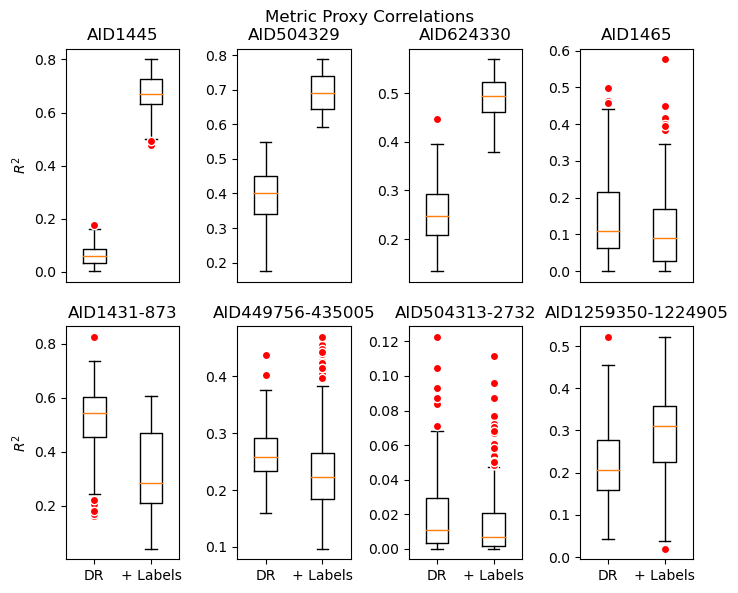

In [7]:
fig, axs = plt.subplots(2, 4, figsize=(7, 6))
fig.suptitle("Metric Proxy Correlations")
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
fig.tight_layout()

axs[0][0].set_ylabel("$R^2$")
axs[1][0].set_ylabel("$R^2$")

for i, (ax, dataset) in enumerate(zip(axs.flatten(), datasets)):
    dr_df = get_all_trial_results(_get_log_dir(dataset, 'baseline_0', 'DROnly'))
    dr_with_labels_df = get_all_trial_results(_get_log_dir(dataset, 'baseline_0', 'DRWithSDLabels'))
    df = pd.DataFrame({'DR': dr_df['PearsonCorrCoefSquared'], '+ Labels': dr_with_labels_df['PearsonCorrCoefSquared']})
    ax.set_title(dataset)
    ax.boxplot(df, flierprops=red_circle, labels=df.columns, widths=0.4)
    if i < 4:
        ax.set_xticks([])
fig.savefig(config.FIGURES_DIR / 'baseline_r2_box_plot.png')

### Label and Prediction Distributions

In [ ]:
num_bins = 10
fig, axs = plt.subplots(2, 4, figsize=(4, 10))
fig.suptitle("Metric Proxy Correlations")

for dataset in datasets:
    raw_dataset = get_dataset(dataset, dataset_usage=DatasetUsage.DROnly)
    label_scaler = fit_label_scaler(raw_dataset, StandardScaler)
    model = _get_best_model(dataset)
    bins = np.linspace(0, 1, num_bins)
    hist(dataset.data.y, bins, alpha=0.5, label='Labels')
    hist(predictions, bins, alpha=0.5, label='Predictions')

## NAS
### Parallel Coordinates

In [18]:
search_space = construct_search_space('simple')

In [146]:
searched_archs = defaultdict(list)
for dataset in datasets:
    losses = []
    trials = load_trials(dataset, 'hyperopt_baseline_tpe_0')
    for trial in trials.trials:
        spec = hyperopt.base.spec_from_misc(trial['misc'])
        arch = hyperopt.space_eval(search_space, spec)
        searched_archs['No. Layers'].append(arch['layers']['num'])
        searched_archs['No. Features'].append(arch['layers']['hidden_features'])
        layers = {t.name: 0 for t in GNNLayerType}
        for layer in arch['layers']['layer_types']:
            layers[layer.name] += 1
        for t, count in layers.items():
            searched_archs['No. ' + t].append(count)
        searched_archs['Pooling Function'].append(arch['pool_func'].name)
        losses.append(trial['result']['metrics']['PearsonCorrCoefSquared'])
    losses = np.array(losses)
    losses = (losses - losses.min()) / (losses.max() - losses.min())
    searched_archs['Scaled R2'].extend(losses)

searched_architectures = pd.DataFrame(searched_archs)

In [144]:
searched_archs = defaultdict(list)
for dataset in datasets:
    trials = load_trials(dataset, 'hyperopt_baseline_tpe_0')
    trial = trials.best_trial
    spec = hyperopt.base.spec_from_misc(trial['misc'])
    arch = hyperopt.space_eval(search_space, spec)
    searched_archs['No. Layers'].append(arch['layers']['num'])
    searched_archs['No. Features'].append(arch['layers']['hidden_features'])
    layers = {t.name: 0 for t in GNNLayerType}
    for layer in arch['layers']['layer_types']:
        layers[layer.name] += 1
    for t, count in layers.items():
        searched_archs['No. ' + t].append(count)
    searched_archs['Pooling Function'].append(arch['pool_func'].name)
    losses = np.array(trials.losses())
    loss = trial['result']['metrics']['PearsonCorrCoefSquared']
    searched_archs['Scaled R2'].append((loss - losses.min()) / (losses.max() - losses.min())

searched_architectures = pd.DataFrame(searched_archs)

In [147]:
fig = ex.parallel_coordinates(
    searched_architectures,
    color='Scaled R2',
    color_continuous_scale=ex.colors.sequential.matter,
)
fig.write_html('bla.html', auto_open=True)

## Explainability

## Zero-cost Proxies
### Correlations

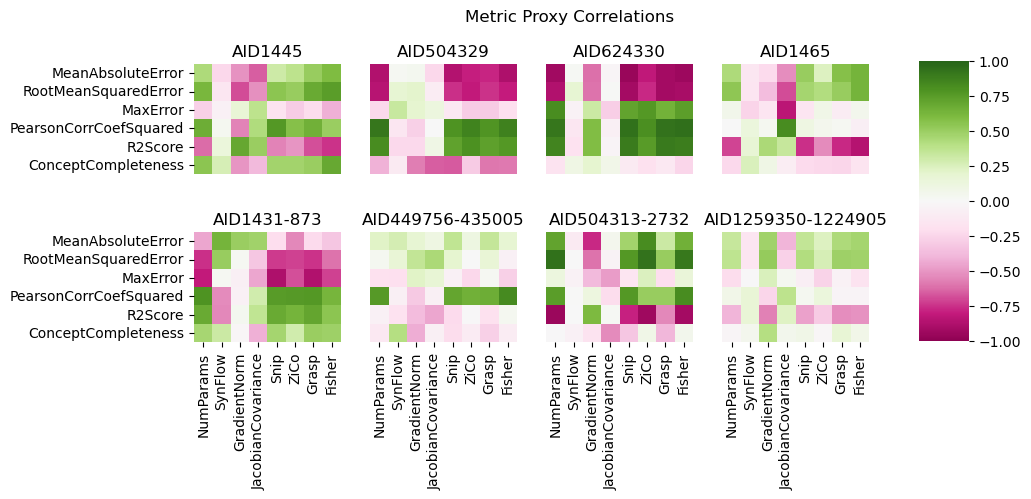

In [12]:
fig, axs = plt.subplots(2, 4, figsize=(10, 4))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
for i, (ax, dataset) in enumerate(zip(axs.flatten(), datasets)):
    ax.set_title(dataset)
    experiment_df = get_all_trial_results(_get_log_dir(dataset, 'baseline_0', 'DROnly'))
    corrs = experiment_df.groupby('trial').mean().corr()
    sns.heatmap(
        corrs[proxy_names].loc[metric_names, :],
        xticklabels=i >= 4,
        yticklabels=i == 0 or i == 4,
        annot=False,
        square=True,
        ax=ax,
        cmap='PiYG',
        cbar_ax=cbar_ax,
        vmin=-1.0,
        vmax=1,
        center=0,
    )
fig.savefig(config.FIGURES_DIR / 'metric_proxy_correlations.png')